In [1]:
import time
import os
import sys
import numpy as np

#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')

import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
plt.close('all')
mmirs = WFSFactory(wfs="mmirs")
f9wfs = WFSFactory(wfs="newf9", pup_offset=[0.3, 0.])
f5wfs = WFSFactory(wfs="f5")

<IPython.core.display.Javascript object>


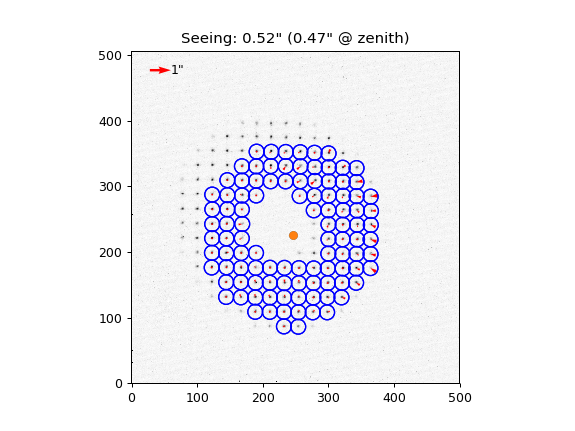

In [5]:
mmirs_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
mmirs_results = mmirs.measure_slopes(mmirs_file, plot=True)
mmirs_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


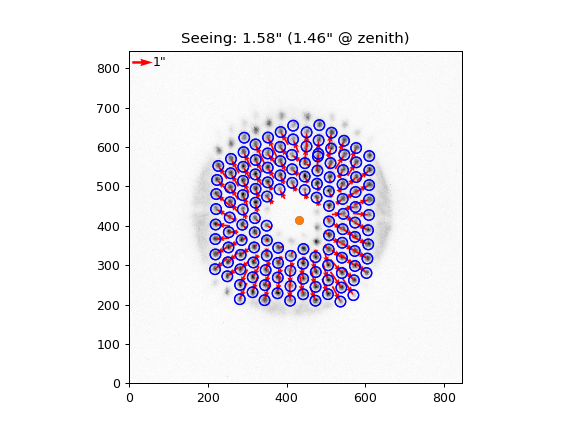

In [15]:
f9_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
f9_results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
f9_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


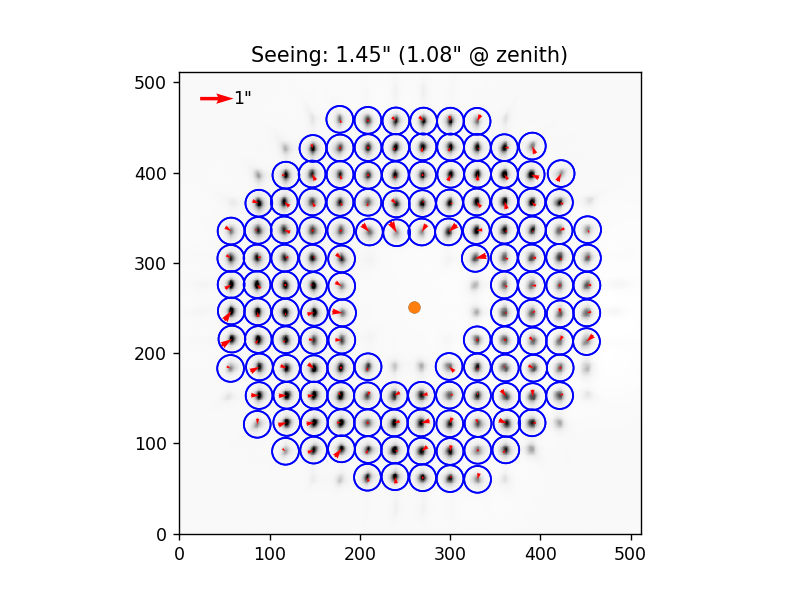

In [6]:
f5_file = "/home/tim/MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
f5_results['figures']['slopes'].show()

In [12]:
plt.close('all')